In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


Lets begin by loading the data.

In [2]:
df = pd.read_csv('avocado.csv', index_col=0)

df.head(5)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,27-12-15,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,20-12-15,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,13-12-15,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,06-12-15,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,29-11-15,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Lets convert date to datetime type and also type to a category so they can be useful later in the model. And reset the index to avoid duplicates.

In [3]:
df = df.reset_index(drop=True)
df['type'] = df['type'].astype('category')
df['type'] = df['type'].cat.codes

There are obvious differences between regions/cities in terms of volumes. Some like their guacamole more than others. 

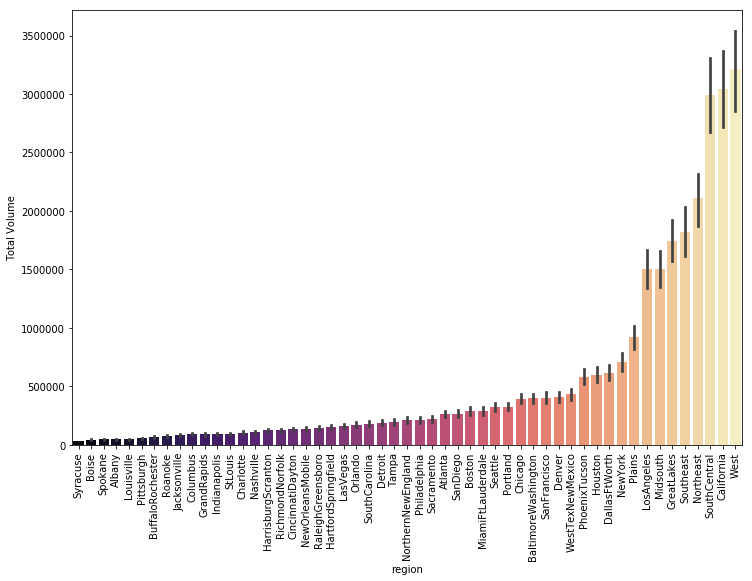

In [4]:
filter1=df.region!='TotalUS'
data1=df[filter1]

sorted_average = data1.groupby(["region"])['Total Volume'].aggregate(np.mean).reset_index().sort_values('Total Volume')

fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation=90)
ax=sns.barplot(x='region',y='Total Volume', data=data1, palette='magma', order=sorted_average['region'])

Not everyones pays the same for organic avocados, southern states (close to Mexico) seem to benefit from better prices. This is not surprising taking into account Mexico represent 45% of all the avocado exports in the world. Ay caramba!

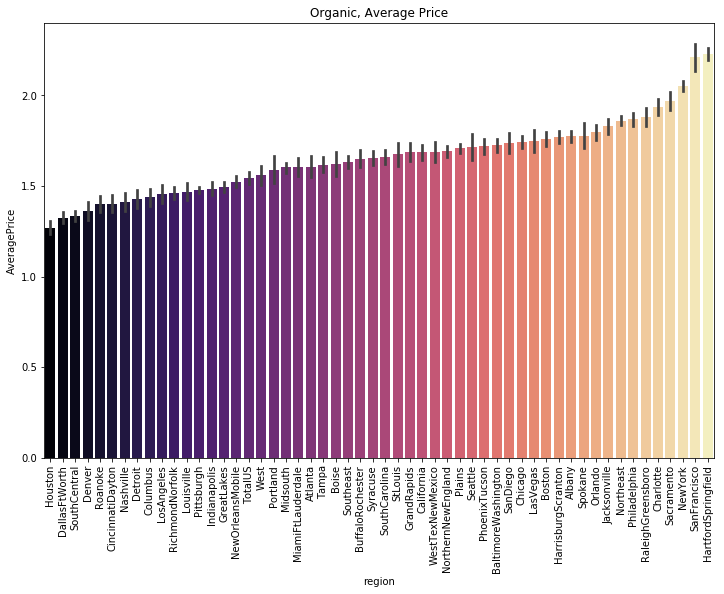

In [5]:
filter2=df['type']==1
data2=df[filter2]

sorted_average = data2.groupby(["region"])['AveragePrice'].aggregate(np.mean).reset_index().sort_values('AveragePrice')

fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation=90)
plt.title('Organic, Average Price')
ax=sns.barplot(x='region',y='AveragePrice', data=data2, palette='magma', order=sorted_average['region'])

The story repeats itself with the conventional type, it is much cheaper for states closer to Mexico and also close to California which also has a significant production of hass avocados. 

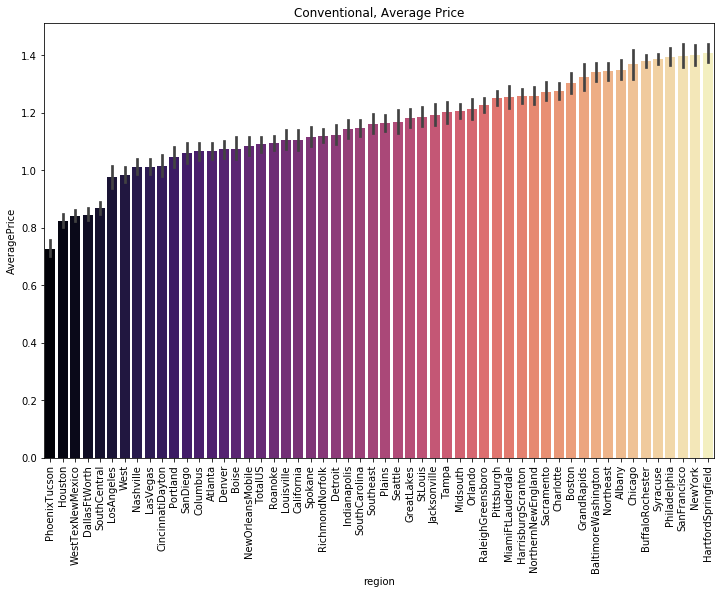

In [6]:
filter2=df['type']==0
data2=df[filter2]


sorted_average = data2.groupby(["region"])['AveragePrice'].aggregate(np.mean).reset_index().sort_values('AveragePrice')

fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation=90)
plt.title('Conventional, Average Price')
ax=sns.barplot(x='region',y='AveragePrice', data=data2, palette='magma', order=sorted_average['region'])

Obvious price differences between organic and conventional, which is no surprise since it costs more to grow organic and this 
type of fruit caters to a premium segment of the market. Except for 2017, prices for conventional avocados have been quite stable on average. 

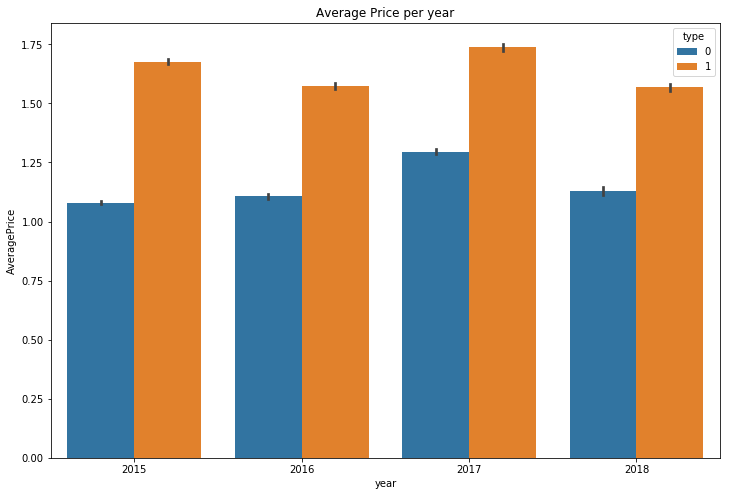

In [7]:
filter3=df['region']!='TotalUS'
data3=df[filter3]

fig, ax = plt.subplots(figsize=(12, 8))
plt.title('Average Price per year')
g = sns.barplot(x = 'year', y = 'AveragePrice', hue='type', data=data3)

Year after year the volumes are growing steadily for both kinds of hass avocado. 

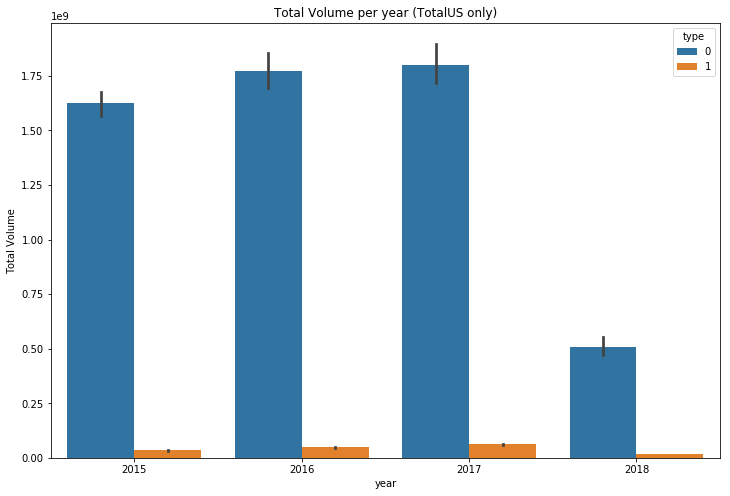

In [8]:
filter3=df['region']=='TotalUS'
data3=df[filter3]

fig, ax = plt.subplots(figsize=(12, 8))
plt.title('Total Volume per year (TotalUS only)')
g = sns.barplot(x = 'year', y = 'Total Volume', hue='type', data=data3, estimator=sum)

Lets see how Volumes and Average Prices relate to each other. There is a slight tendency for lower prices when volumes are significantly large, which is usually what happens in any market in terms of pricing.  

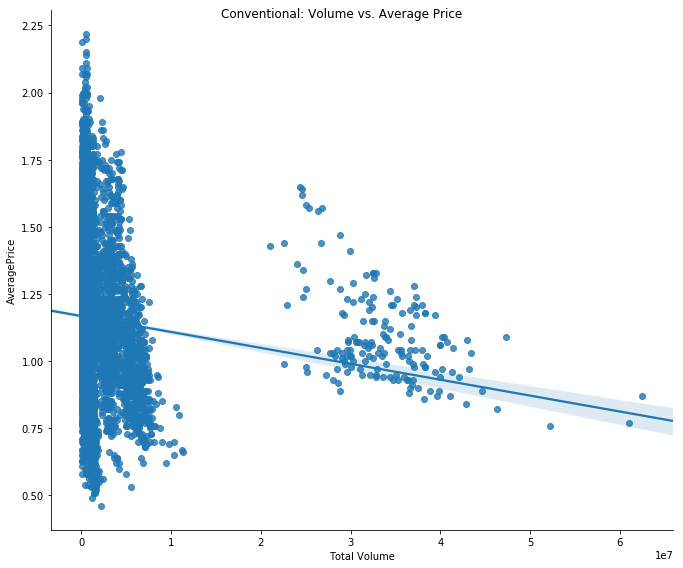

In [9]:
filter5=df['type']==0
data5=df[filter5]

g = sns.lmplot(x='Total Volume',y='AveragePrice', data=data5, fit_reg=True, height=8, aspect=1.2)
fig = g.fig
fig.suptitle("Conventional: Volume vs. Average Price")
plt.show()

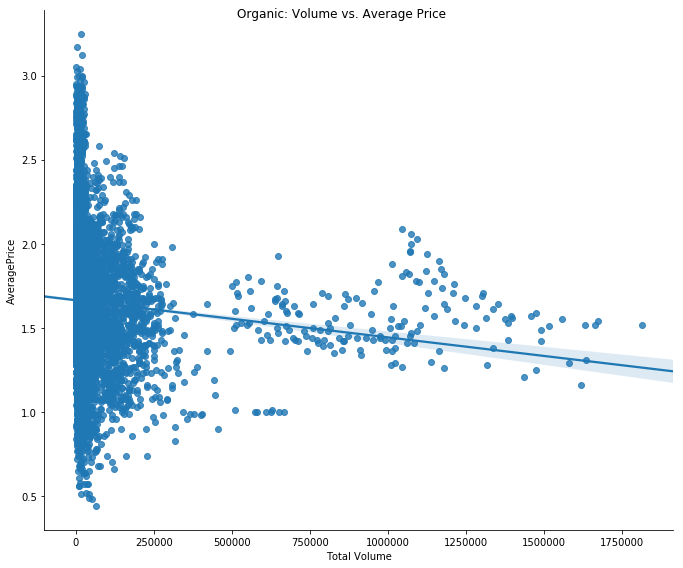

In [10]:
filter5=df['type']==1
data5=df[filter5]

g = sns.lmplot(x='Total Volume',y='AveragePrice', data=data5, fit_reg=True, height=8, aspect=1.2)
fig = g.fig
fig.suptitle("Organic: Volume vs. Average Price")
plt.show()

Now lets see how the features correlate with each other.

All the numeric features correlate highly with each other and none with the label (AveragePrice). Type is moderately correlated to AveragePrice which was evident by the differences in prices between conventional and organic avocados which was displayed in the visualizations. 

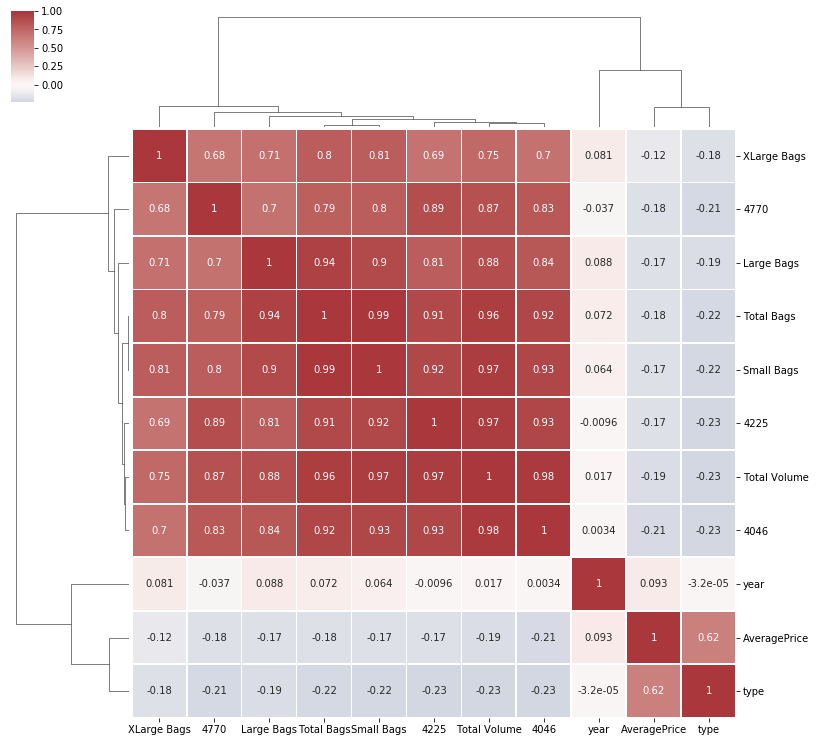

In [11]:
sns.clustermap(df.corr(), center=0, cmap="vlag", annot = True, linewidths=.75, figsize=(13, 13));

Finally, lets do a pairing of all the numeric features in order to clearly visualize the above results. 

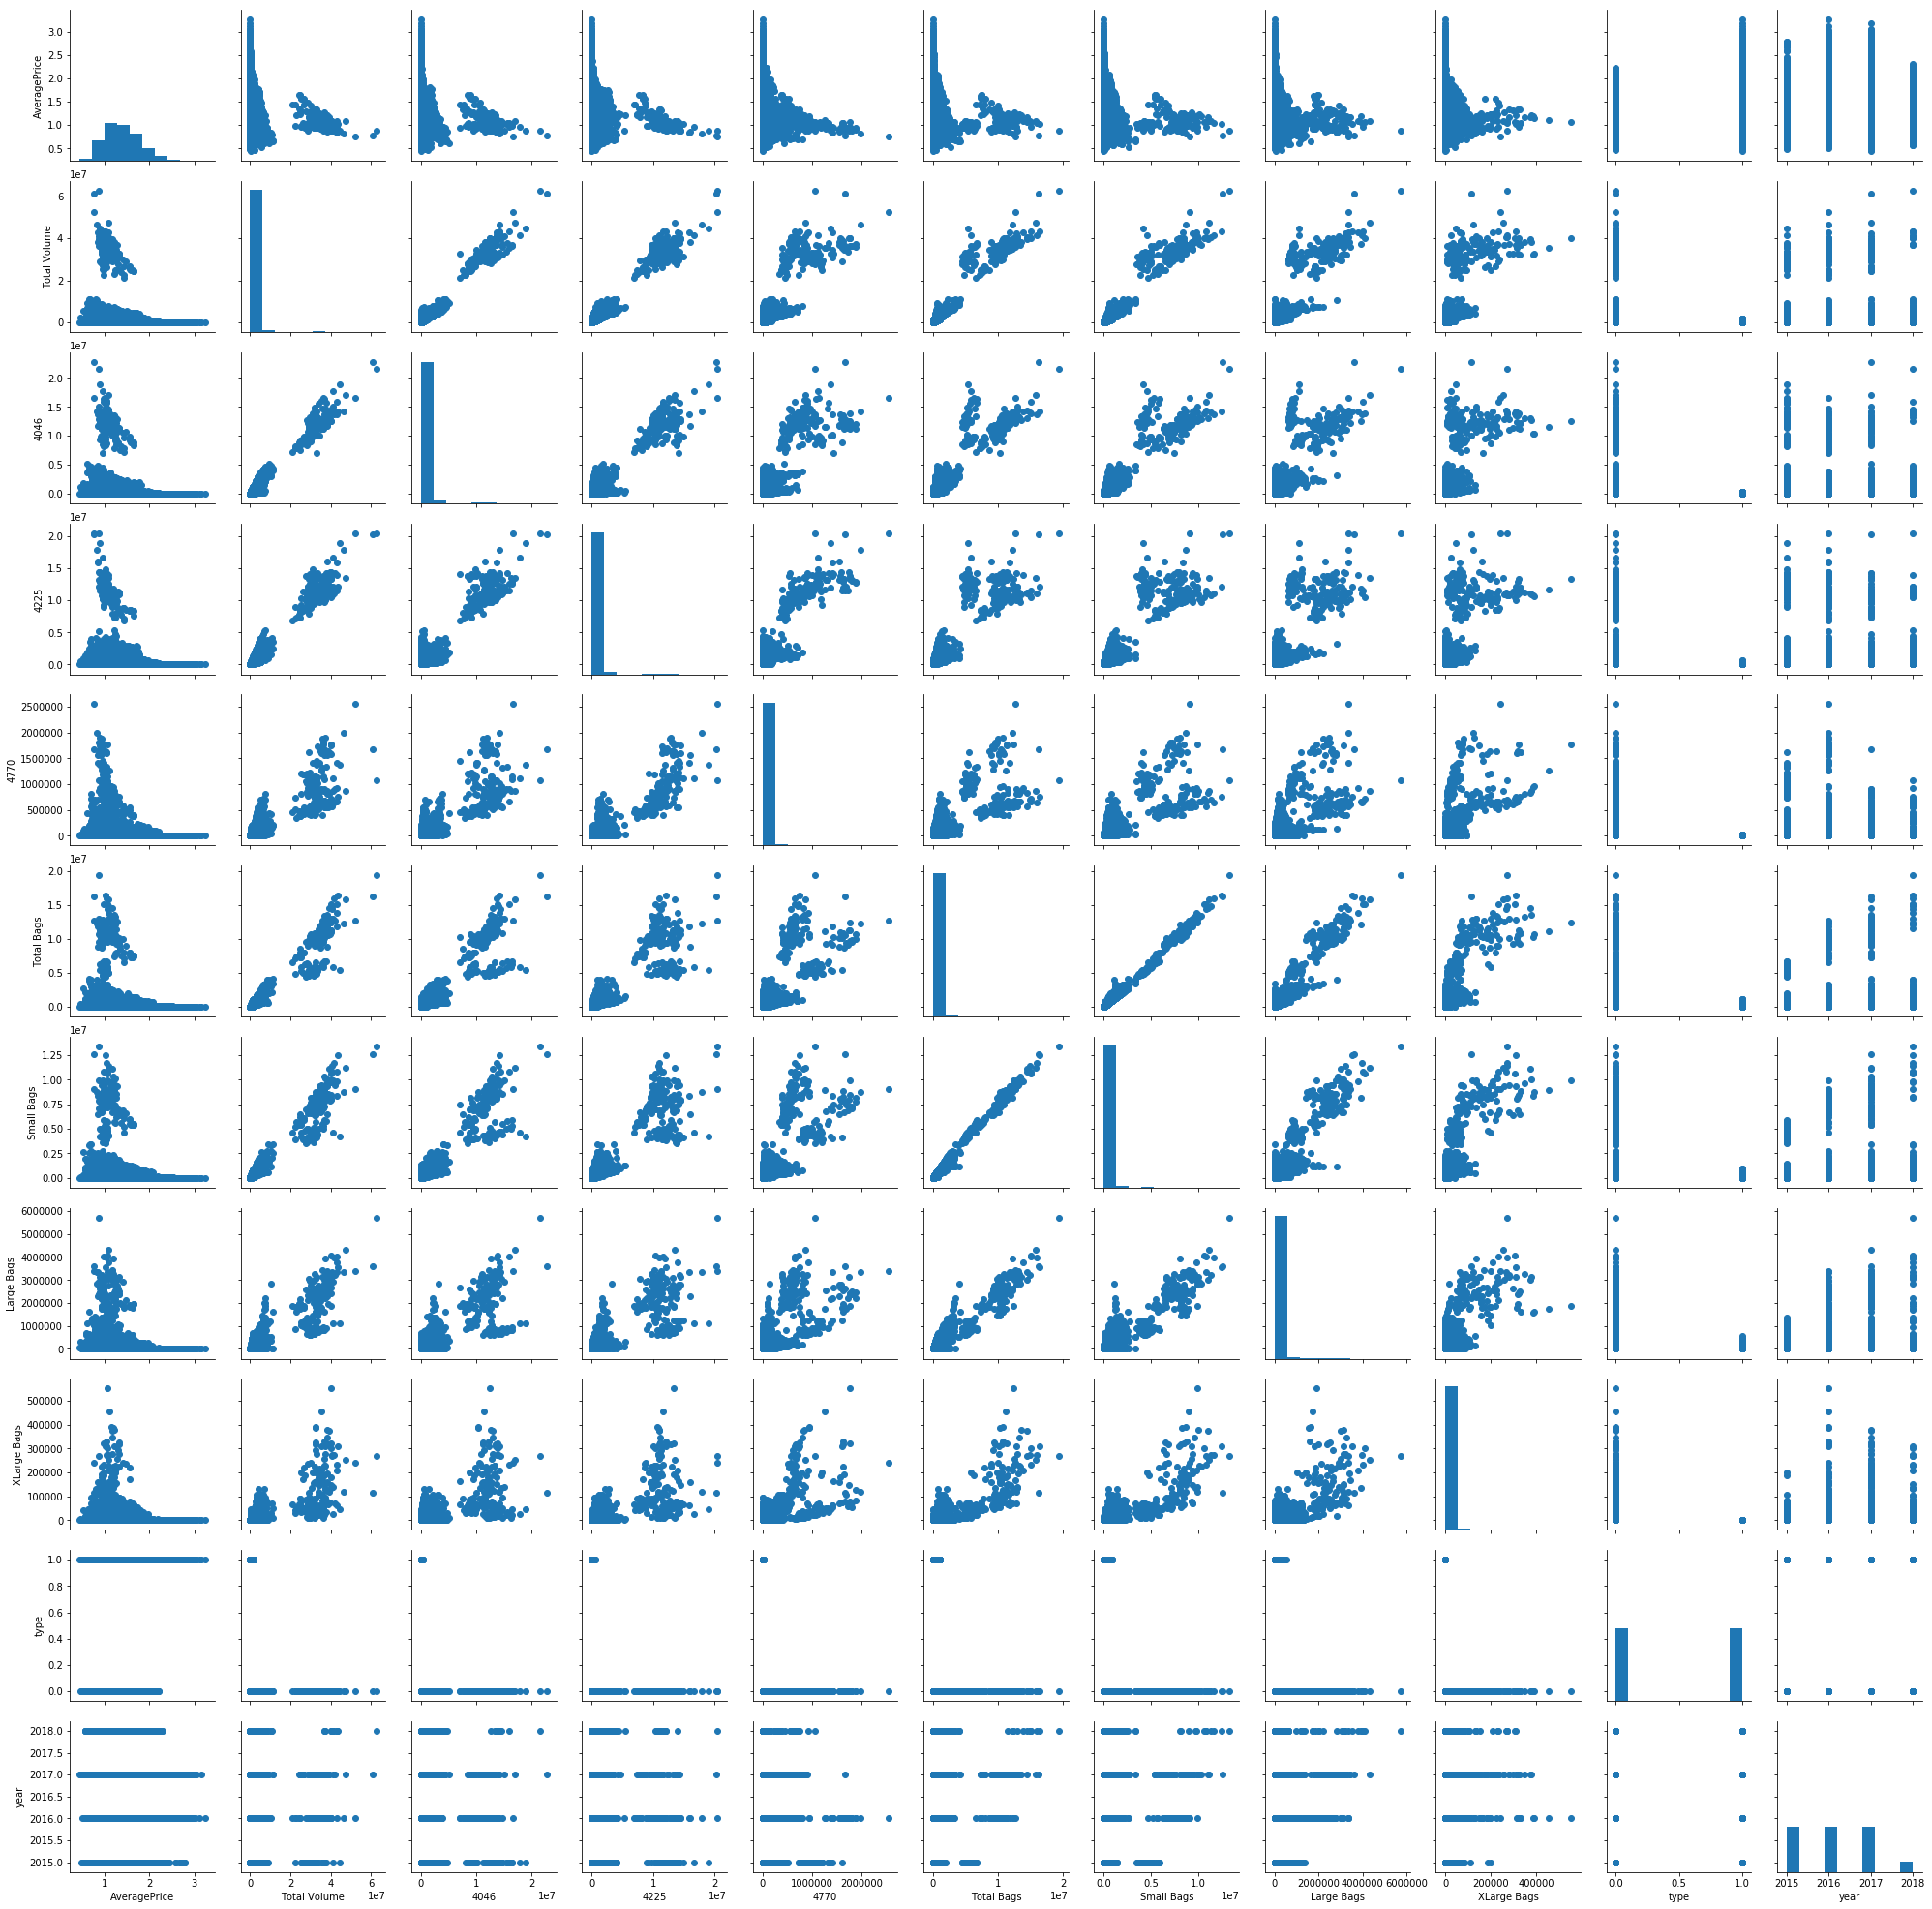

In [12]:
g = sns.PairGrid(df)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter);

# Models

Visualizations are always nice but lets get to the reason we are here. Lets start with Random Forest which seems to be the more suitable for these job. 

Lets convert our region feature so we can use it in the model. We will keep the region column for later. 

In [13]:
df['fregion'] = df['region'].values
df = pd.get_dummies(df, columns=['fregion'])
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,...,fregion_SouthCarolina,fregion_SouthCentral,fregion_Southeast,fregion_Spokane,fregion_StLouis,fregion_Syracuse,fregion_Tampa,fregion_TotalUS,fregion_West,fregion_WestTexNewMexico
0,27-12-15,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,...,0,0,0,0,0,0,0,0,0,0
1,20-12-15,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,...,0,0,0,0,0,0,0,0,0,0
2,13-12-15,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,...,0,0,0,0,0,0,0,0,0,0
3,06-12-15,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,...,0,0,0,0,0,0,0,0,0,0
4,29-11-15,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,...,0,0,0,0,0,0,0,0,0,0


Lets train the data and score it. Nice it seems this the right model. 

In [14]:
drop_list = ['AveragePrice', 'Date', 'region']

X = df.drop(drop_list, axis=1)
y = df['AveragePrice'].values.ravel()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

clf = RandomForestRegressor(n_estimators= 100, random_state=42)
clf.fit(Xtrain,ytrain)

scores = cross_val_score(clf, Xtrain, ytrain, cv=3, n_jobs=-1)

print(f"{round(np.mean(scores),3)*100}% accuracy")
print(f"MSE {mean_squared_error(y_pred=clf.predict(Xtest), y_true=ytest)}")

83.5% accuracy
MSE 0.02331936870136986


And now lets evaluate the predictions. We have USD 0.105 difference on average on the predictions given by the Random Forest. Not bad. And lets see how the predictions look in a histogram. Not too bad, most prediction fall between 0 and 20 cents. 

R2 score: 0.8585467941897666
Mean absolute error:  0.10577413698630139 USD


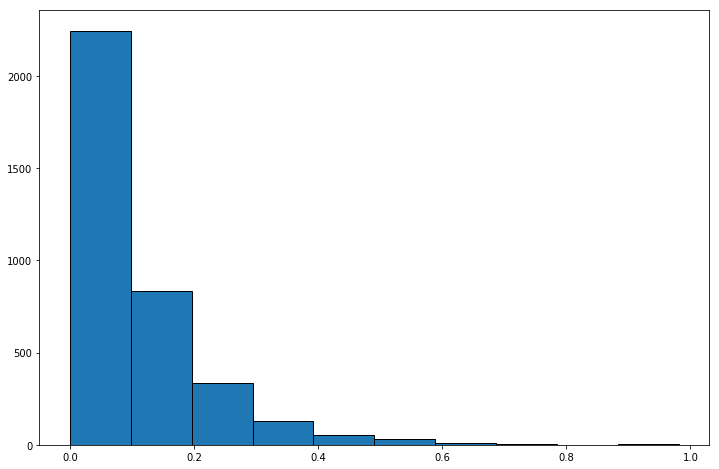

In [15]:
predictions = clf.predict(Xtest)

#print(predictions)
# Calculate the absolute errors
errors = abs(predictions - ytest)

fig, ax = plt.subplots(figsize=(12, 8))
plt.hist(errors, bins = 10, edgecolor = 'black');
# Print out the mean absolute error (mae)
#print(f"Test: {mean_squared_error(ytest, predictions)} ")
print(f"R2 score: {r2_score(ytest, predictions)}")
print(f"Mean absolute error:  {mean_absolute_error(ytest, predictions)} USD")

Lets plot the predictions vs reality. 

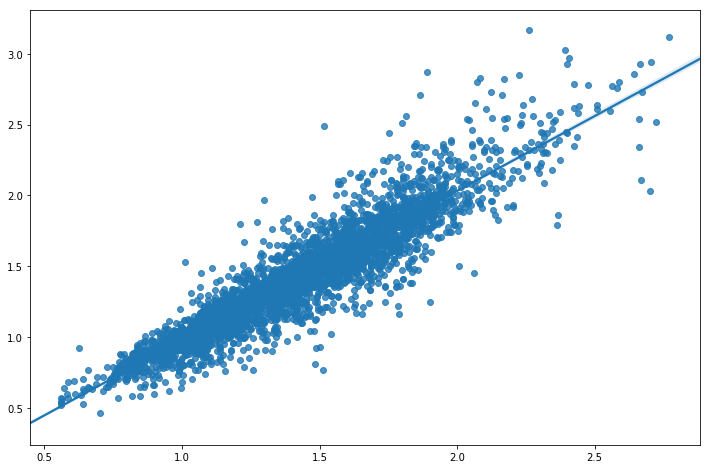

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
g = sns.regplot(x = predictions,y = ytest)

Lets check out now which features are important for the model. 

In [17]:
# Get numerical feature importances
importances = list(clf.feature_importances_)

feature_list = list(X.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: type                 Importance: 0.38
Variable: 4046                 Importance: 0.1
Variable: Large Bags           Importance: 0.09
Variable: 4225                 Importance: 0.07
Variable: Total Volume         Importance: 0.05
Variable: Total Bags           Importance: 0.05
Variable: year                 Importance: 0.05
Variable: 4770                 Importance: 0.04
Variable: Small Bags           Importance: 0.04
Variable: XLarge Bags          Importance: 0.02
Variable: fregion_SanFrancisco Importance: 0.02
Variable: fregion_HartfordSpringfield Importance: 0.01
Variable: fregion_Albany       Importance: 0.0
Variable: fregion_Atlanta      Importance: 0.0
Variable: fregion_BaltimoreWashington Importance: 0.0
Variable: fregion_Boise        Importance: 0.0
Variable: fregion_Boston       Importance: 0.0
Variable: fregion_BuffaloRochester Importance: 0.0
Variable: fregion_California   Importance: 0.0
Variable: fregion_Charlotte    Importance: 0.0
Variable: fregion_Chicago      

Well type is an important feature for the model. Again, we were expecting that. But we also see how Large Bags, 4046, 4225, Total Volume, basically all the numeric features, carry a decent weight in the model's predictions. And this for me is a PROBLEM since this data is totally dependant on sales activity. We wouldn't have this kind of data if we would attempt to predict future prices. Therefore I think these features cannot be considered as part of the solution. So lets try something else. 

Lets add a few new features and see if they can replace some of these numeric features.  We will add features that would be readily available for future predictions.

Since there are significant differences in prices among different regions lets add a grouping using the Economic Analysis Region categories. Lets also add seasons, since produce is usually very season dependant. And lets convert the date to numeric months. 

In [18]:
EconomicAnalysisRegion = []

for region in df['region']:
    if region in ['California', 'LasVegas', 'LosAngeles', 'Portland', 'Sacramento', 'SanDiego', 'SanFrancisco', 'Seattle', 'Spokane']:
        EconomicAnalysisRegion.append('Far West')
    elif region in ['Chicago', 'CincinnatiDayton', 'Columbus', 'Detroit', 'GrandRapids', 'Indianapolis']:
        EconomicAnalysisRegion.append('Great Lakes')
    elif region in ['GreatLakes']:
        EconomicAnalysisRegion.append('GreatLakes')
    elif region in ['Albany', 'BaltimoreWashington', 'BuffaloRochester', 'HarrisburgScranton', 'HartfordSpringfield', 'NewYork', 'Philadelphia', 'Pittsburgh', 'Syracuse']:
        EconomicAnalysisRegion.append('Mideast')
    elif region in ['Midsouth']:
        EconomicAnalysisRegion.append('Midsouth') 
    elif region in ['Boston', 'HartfordSpringfield']:
        EconomicAnalysisRegion.append('New England') 
    elif region in ['Northeast']:
        EconomicAnalysisRegion.append('Northeast')
    elif region in ['NorthernNewEngland']:
        EconomicAnalysisRegion.append('NorthernNewEngland')
    elif region in ['Plains', 'StLouis']:
        EconomicAnalysisRegion.append('Plains')
    elif region in ['Boise', 'Denver']:
        EconomicAnalysisRegion.append('Rocky Mountains')
    elif region in ['SouthCarolina']:
        EconomicAnalysisRegion.append('SouthCarolina')
    elif region in ['SouthCentral']:
        EconomicAnalysisRegion.append('SouthCentral')
    elif region in ['Atlanta', 'Charlotte', 'Jacksonville', 'Louisville', 'MiamiFtLauderdale', 'Nashville', 'NewOrleansMobile', 'Orlando', 'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Southeast']:
        EconomicAnalysisRegion.append('Southeast')
    elif region in ['DallasFtWorth', 'Houston', 'PhoenixTucson', 'Tampa']:
        EconomicAnalysisRegion.append('SouthWest')
    elif region in ['TotalUS']:
        EconomicAnalysisRegion.append('TotalUS')
    elif region in ['West']:
        EconomicAnalysisRegion.append('West')
    elif region in ['WestTexNewMexico']:
        EconomicAnalysisRegion.append('WestTexNewMexico')
        

df['Economic Analysis Region'] = EconomicAnalysisRegion

df = pd.get_dummies(df, columns=['Economic Analysis Region'])

In [19]:
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month

seasons = []

for month in df['month']:
    if month in [1, 2, 12]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    elif month in [9, 10, 11]:
        seasons.append('fall')
                
df['season'] = seasons
df = pd.get_dummies(df, columns=['season'])

In [20]:
df.head(5)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,...,Economic Analysis Region_SouthWest,Economic Analysis Region_Southeast,Economic Analysis Region_TotalUS,Economic Analysis Region_West,Economic Analysis Region_WestTexNewMexico,month,season_fall,season_spring,season_summer,season_winter
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,...,0,0,0,0,0,12,0,0,0,1
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,...,0,0,0,0,0,12,0,0,0,1
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,...,0,0,0,0,0,12,0,0,0,1
3,2015-06-12,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,...,0,0,0,0,0,6,0,0,1,0
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,...,0,0,0,0,0,11,1,0,0,0


Now lets run the model again dropping the features which are not useful and only considering the new features. 

In [21]:
drop_list = ['AveragePrice', 'Date', '4046', '4225', '4770', 'Total Bags', 'Total Volume', 'region', 'Small Bags', 'Large Bags', 'XLarge Bags']

X = df.drop(drop_list, axis=1)
y = df['AveragePrice'].values.ravel()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestRegressor(n_estimators= 100, random_state=42)

clf.fit(Xtrain,ytrain)

scores = cross_val_score(clf, Xtrain, ytrain, cv=3, n_jobs=-1)

print(f"{round(np.mean(scores),3)*100}% accuracy")
print(f"MSE {mean_squared_error(y_pred=clf.predict(Xtest), y_true=ytest)}")

61.7% accuracy
MSE 0.05503047415209829


Big drop compared to the previous model. Not looking so good. Lets see how the predictions fair out. 

Mean Absolute Error: USD 0.164


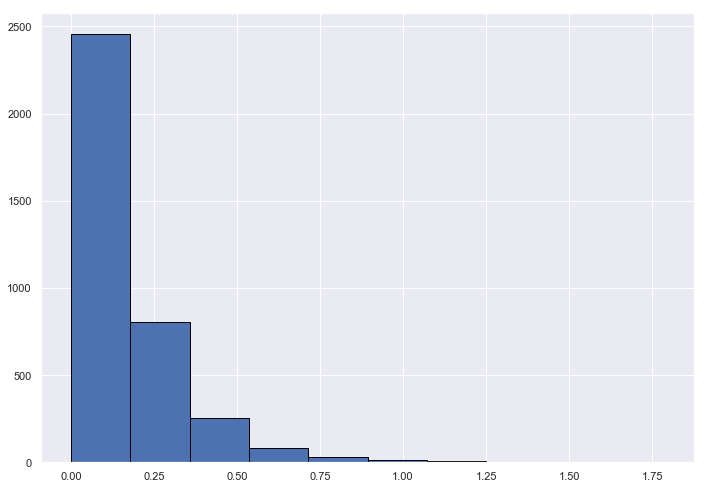

In [22]:
predictions = clf.predict(Xtest)

#print(predictions)
# Calculate the absolute errors
errors = abs(predictions - ytest)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(errors, bins = 10, edgecolor = 'black');
# Print out the mean absolute error (mae)
print('Mean Absolute Error: USD', round(np.mean(errors), 3))

5.9 cents worse. But most predictions fall between 0 and 20 cents. So not so terrible after all. Better than guessing right?

Lets see which features were more important for the model. Its seems the type remains even stronger. 

In [23]:
# Get numerical feature importances
importances = list(clf.feature_importances_)

feature_list = list(X.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: type                 Importance: 0.44
Variable: month                Importance: 0.09
Variable: year                 Importance: 0.08
Variable: fregion_SanFrancisco Importance: 0.03
Variable: Economic Analysis Region_Mideast Importance: 0.03
Variable: fregion_HartfordSpringfield Importance: 0.02
Variable: Economic Analysis Region_SouthWest Importance: 0.02
Variable: fregion_Charlotte    Importance: 0.01
Variable: fregion_Chicago      Importance: 0.01
Variable: fregion_DallasFtWorth Importance: 0.01
Variable: fregion_Denver       Importance: 0.01
Variable: fregion_GrandRapids  Importance: 0.01
Variable: fregion_Houston      Importance: 0.01
Variable: fregion_LosAngeles   Importance: 0.01
Variable: fregion_Nashville    Importance: 0.01
Variable: fregion_NewYork      Importance: 0.01
Variable: fregion_RaleighGreensboro Importance: 0.01
Variable: fregion_Sacramento   Importance: 0.01
Variable: fregion_SouthCentral Importance: 0.01
Variable: fregion_Tampa        Importance: 0.01
V

It seems Random Forest will fall short this the data we have available, so lets try Prophet. 

In [24]:
from fbprophet import Prophet

In [34]:
m = Prophet()
df = pd.read_csv('avocado.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])

mask = (df['region'] == 'TotalUS') & (df['type'] == 'conventional')
df = df[mask]

df.rename(columns={'Date': 'ds', 'AveragePrice': 'y'}, inplace=True)
m.fit(df);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\gcomercial\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [35]:
future = m.make_future_dataframe(periods=52,freq='w')
future.tail(3)

,ds
218,2019-10-13
219,2019-10-20
220,2019-10-27


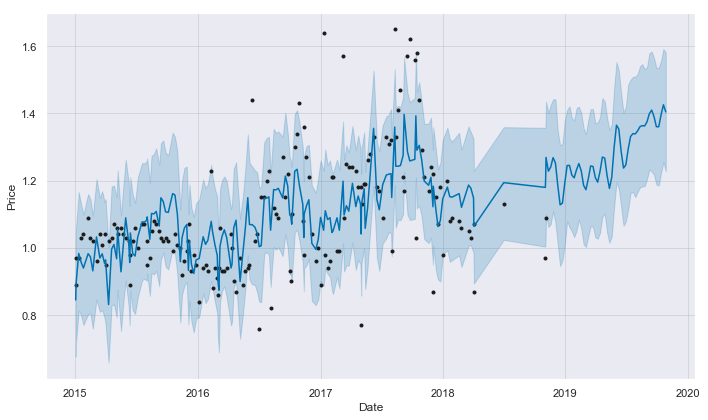

In [36]:
forecast = m.predict(future)
m.plot(forecast, xlabel = 'Date', ylabel = 'Price');

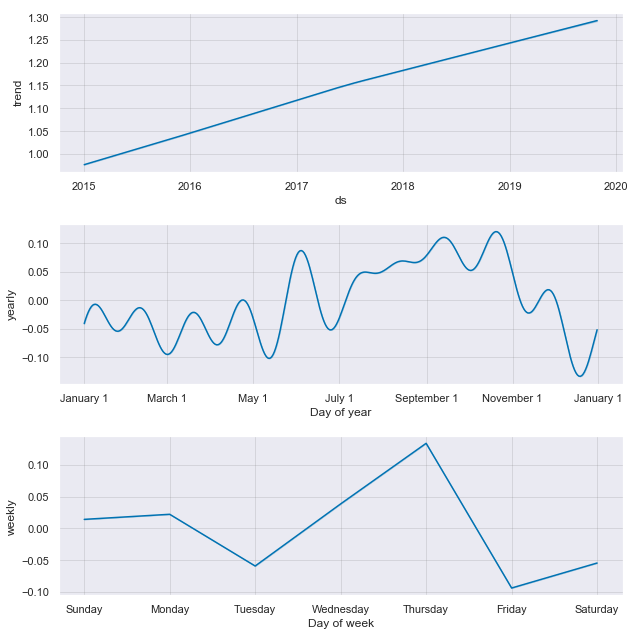

In [37]:
fig2 = m.plot_components(forecast)

In [29]:
cmp_df = df.join(forecast.set_index('ds'), on='ds')
cmp_df = cmp_df[cmp_df['y'].notnull()]

So $0.104 cents off on average which is 0.01 better than Random Forest using the (useless) numeric features. It seems Prophet is definitely better suited for the job. 

In [30]:
print(f"MSE {mean_squared_error(y_pred=cmp_df.yhat, y_true=cmp_df.y)}")
print(f"R2 score: {r2_score(cmp_df.y, cmp_df.yhat)}")
print(f"Mean absolute error:  {mean_absolute_error(cmp_df.y, cmp_df.yhat)} USD")

MSE 0.018610414982764622
R2 score: 0.3824926341301462
Mean absolute error:  0.10413503917946508 USD


Most predictions fall between 0 and 0.20 cents absolute difference. 

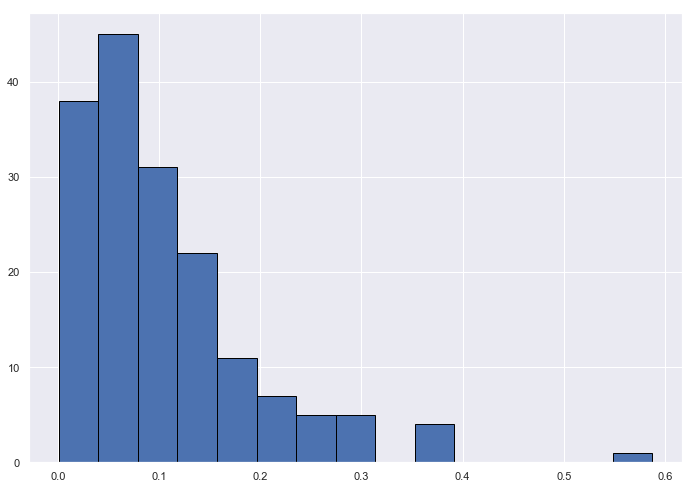

In [31]:
errors = abs(cmp_df.yhat - cmp_df.y)
plt.hist(errors, bins = 15, edgecolor = 'black');

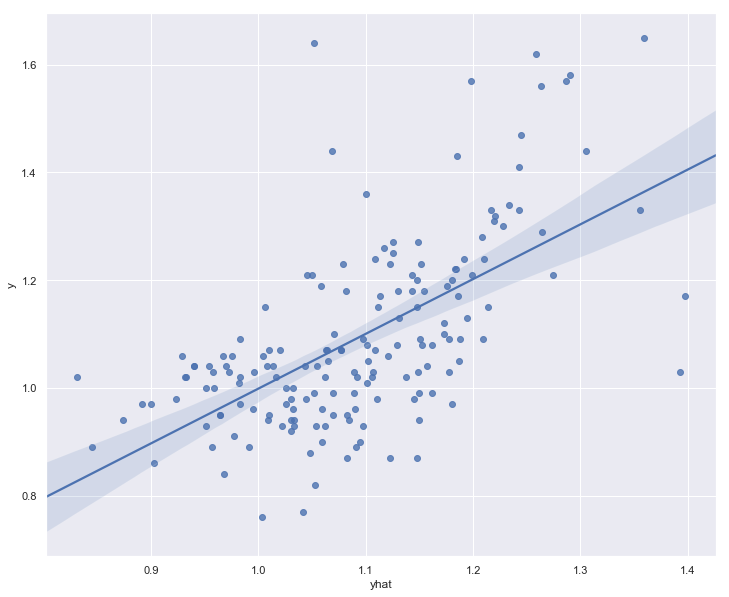

In [32]:
sns.set(rc={'figure.figsize':(12,10)})
g = sns.regplot(x = cmp_df.yhat,y = cmp_df.y)

Lets now try it with the Houston data and the organic variety.

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\gcomercial\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


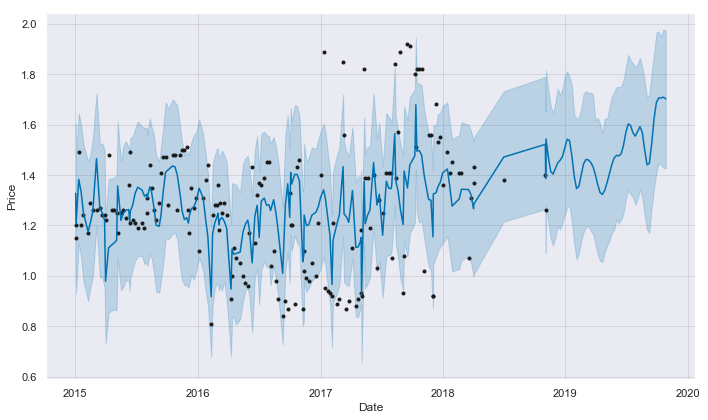

In [50]:
m = Prophet()
df = pd.read_csv('avocado.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])

mask = (df['region'] == 'Houston') & (df['type'] == 'organic')
df = df[mask]

df.rename(columns={'Date': 'ds', 'AveragePrice': 'y'}, inplace=True)
m.fit(df);
future = m.make_future_dataframe(periods=52,freq='w')
forecast = m.predict(future)
m.plot(forecast, xlabel = 'Date', ylabel = 'Price');


In [49]:
cmp_df = df.join(forecast.set_index('ds'), on='ds')
cmp_df = cmp_df[cmp_df['y'].notnull()]

print(f"MSE {mean_squared_error(y_pred=cmp_df.yhat, y_true=cmp_df.y)}")
print(f"R2 score: {r2_score(cmp_df.y, cmp_df.yhat)}")
print(f"Mean absolute error:  {mean_absolute_error(cmp_df.y, cmp_df.yhat)} USD")

MSE 0.01601918508635503
R2 score: 0.2749798823367625
Mean absolute error:  0.09482429703765041 USD


Not bad at all, USD 0.09 absolute error. 